Established Twitter connection.
Read screen names: ['DrJillStein', 'GovGaryJohnson', 'HillaryClinton', 'realDonaldTrump']
found 4 users with screen_names ['DrJillStein', 'GovGaryJohnson', 'HillaryClinton', 'realDonaldTrump']
Friends per candidate:
DrJillStein 1649
GovGaryJohnson 3488
HillaryClinton 769
realDonaldTrump 45
Most common friends:
[(18766459, 3), (19608297, 3), (822215673812119553, 3), (12, 2), (428333, 2)]
Friend Overlap:
[('DrJillStein', 'GovGaryJohnson', 239), ('GovGaryJohnson', 'HillaryClinton', 15), ('GovGaryJohnson', 'realDonaldTrump', 14), ('DrJillStein', 'HillaryClinton', 3), ('HillaryClinton', 'realDonaldTrump', 1), ('DrJillStein', 'realDonaldTrump', 0)]
User followed by Hillary and Donald: ['WhiteHouse']
graph has 270 nodes and 535 edges


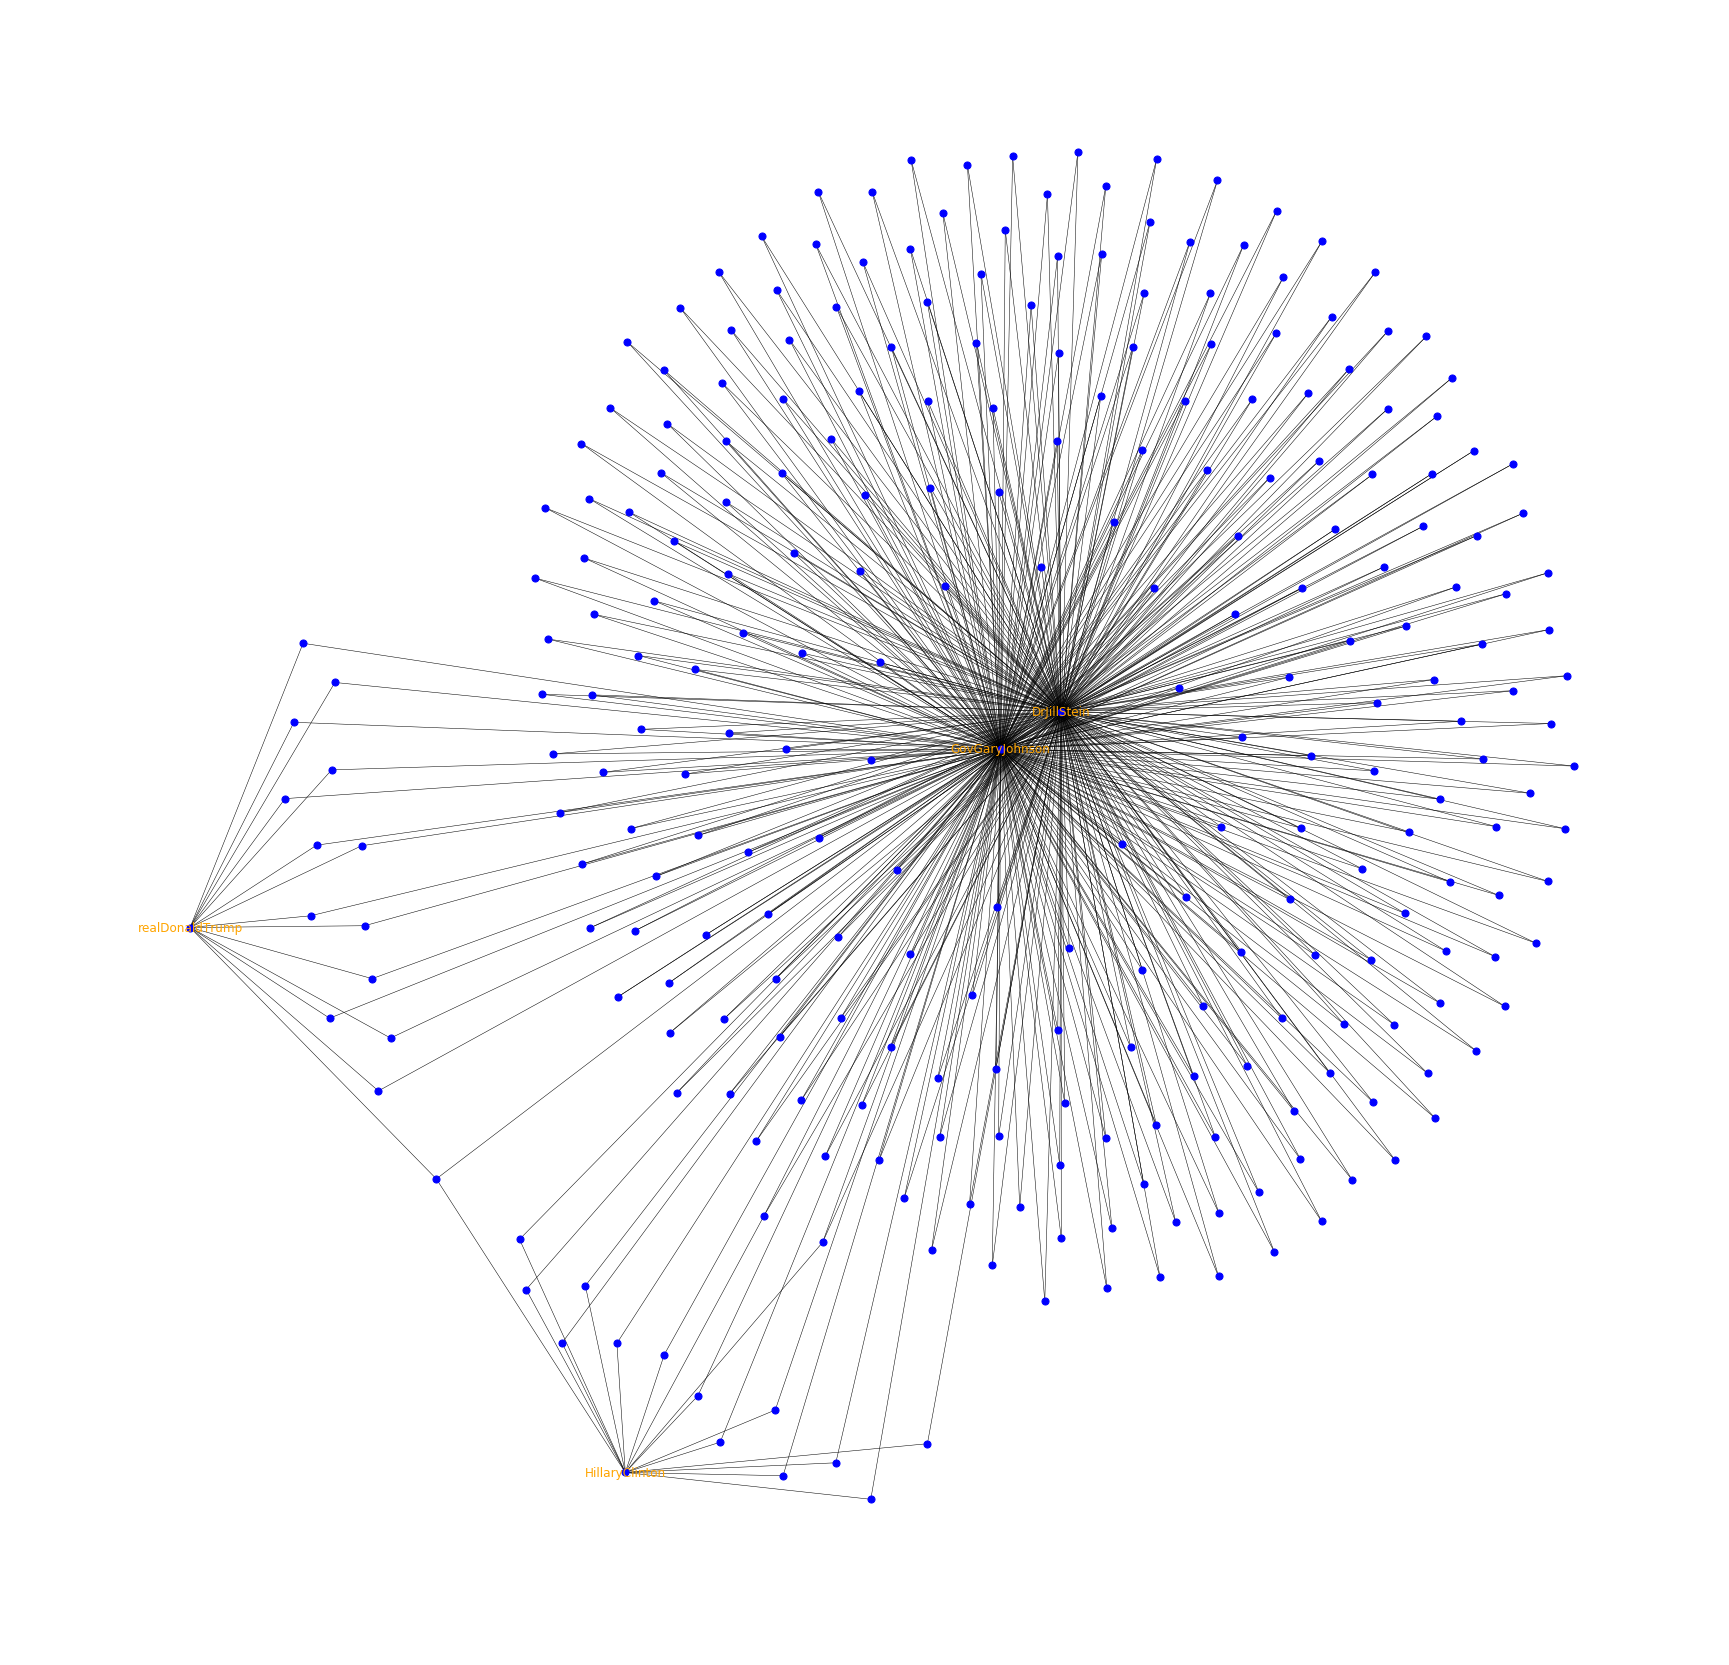

network drawn to network.png


In [3]:
from collections import Counter
import matplotlib.pyplot as plt
import networkx as nx
import sys
import time
from TwitterAPI import TwitterAPI

consumer_key = 'fmEX9EvoyQ5UkJgEhn3K0ckuq'
consumer_secret = 'IKcBtkaBKUEWfEtZJC7e1lSgrx8pzsYXpMW8oh570pfGOxi5eb'
access_token = '4602561163-2uZhnk8R6lXlbnEOtdZhkiER5z8S05FEH9QLnve'
access_token_secret = 'nycUV1POzAz9Uy5QOHlqgaXp00BFEcYv5k9cvtKtQDWGN'

def get_twitter():
    return TwitterAPI(consumer_key, consumer_secret, access_token, access_token_secret)

def read_screen_names(filename):
    with open(filename) as d:
        names = d.read().splitlines()
    d.close()
    return names
    
def robust_request(twitter, resource, params, max_tries=5):
    for i in range(max_tries):
        request = twitter.request(resource, params)
        if request.status_code == 200:
            return request
        else:
            print('Got error %s \nsleeping for 15 minutes.' % request.text)
            sys.stderr.flush()
            time.sleep(61 * 15)
            
def get_users(twitter, screen_names):
    get_u = robust_request(twitter,'users/lookup',{'screen_name': screen_names})
    u_list = []
    for u in get_u:
        u_list.append(u)
    return u_list

def get_friends(twitter, screen_name):
    get_f = robust_request(twitter,'friends/ids',{'screen_name' : screen_name, 'count': 5000})
    f_list = []
    for f in get_f:
        f_list.append(f)
    return (sorted(f_list))

def add_all_friends(twitter, users):
    l = len(users)
    add_friends = []
    for u in range(l):
        users[u]['friends'] = get_friends(twitter, users[u].get('screen_name'))
        
def print_num_friends(users):
    l = len(users)
    candi=[]
    friends=[]
    for n in range(l):
        candi.append(users[n].get('screen_name'))
        friends.append(users[n].get('friends_count'))
    for i in range(l):
        print('%s %s' % (candi[i],friends[i])) 
    
def followed_by_hillary_and_donald(users, twitter):
    h=0
    t=0
    l=len(users)
    for i in range(l):
        if(users[i].get('screen_name') == 'realDonaldTrump'):
            t = i;
        if (users[i].get('screen_name') == 'HillaryClinton'):
            h = i;
    com = set(users[t].get('friends')) & set(users[h].get('friends'))
    common_followed = robust_request(twitter,'users/lookup',{'user_id':com})
    followed_by_h_n_d = list(map (lambda x: x['screen_name'],common_followed))
    return followed_by_h_n_d

def count_friends(users):
    l = len(users)
    count = Counter()
    for i in range(l):
        for j in users[i].get('friends'):
            count[j]=count[j]+1
    return count         
                            
def friend_overlap(users):
    com = 0
    list_overlap = []
    for i in range(len(users)):
        for j in range(i+1,len(users)):
            #common = set(users[i].get('friends')) & set(users[j].get('friends'))
            list_overlap.append((users[i].get('screen_name'),users[j].get('screen_name'),len(set(users[i].get('friends')) & set(users[j].get('friends')))))
    list_sort = sorted(sorted([desc for desc in list_overlap],key=lambda x:x[0]),key=lambda x:x[2],reverse = True)
    return list_sort

def create_graph(users, friend_counts):
    g = nx.Graph()
    l = len(users)
    for i in range(l):
        name = users[i].get('screen_name')
        g.add_node(name)    
    for i in range(l):
        for j in users[i].get('friends'):
            if friend_counts[j] > 1:
                g.add_node(j)
                g.add_edge(j,users[i].get('screen_name'))
    return g
        
def draw_network(graph, users, filename):
    n = dict()
    for u in users:
        n[u['screen_name']] = u['screen_name']
    plt.figure(figsize=(30,30))
    #nx.draw_networkx(graph,labels=pos_nodes,font_weight='bold',node_size=50,font_size=14)
    nx.draw_networkx(graph,labels=n,width=.5,node_size=50,font_size=12,node_color='b',font_color='orange')
    plt.axis("off")
    plt.savefig(filename)
    plt.show()
                
def main():
    """ Main method. You should not modify this. """
    twitter = get_twitter()
    screen_names = read_screen_names('candidates.txt')
    print('Established Twitter connection.')
    print('Read screen names: %s' % screen_names)
    users = sorted(get_users(twitter, screen_names), key=lambda x: x['screen_name'])
    print('found %d users with screen_names %s' %
          (len(users), str([u['screen_name'] for u in users])))
    add_all_friends(twitter, users)
    print('Friends per candidate:')
    print_num_friends(users)
    friend_counts = count_friends(users)
    print('Most common friends:\n%s' % str(friend_counts.most_common(5)))
    print('Friend Overlap:\n%s' % str(friend_overlap(users)))
    print('User followed by Hillary and Donald: %s' % followed_by_hillary_and_donald(users, twitter))

    graph = create_graph(users, friend_counts)
    print('graph has %s nodes and %s edges' % (len(graph.nodes()), len(graph.edges())))
    draw_network(graph, users, 'network.png')
    print('network drawn to network.png')


if __name__ == '__main__':
    main()

    
    

        
